# Interactive Machine Data Analysis
This notebook demonstrates how to run the LLMAD anomaly detection on Machine data.

### 1. Load Environment Variables

First, we load the necessary environment variables from the `.env` file, such as API keys and the model engine to be used.

In [1]:
import os
from dotenv import load_dotenv

# Load environment variables from .env file
load_dotenv()

# You can check the loaded variables here
print(f"Using Model: {os.getenv('MODEL_ENGINE')}")

Using Model: gemini-2.5-pro


### 2. Set Experiment Parameters

Configure the parameters for the analysis.

In [ ]:
YEAR = 2024 # Filter by year (0 for all)
WINDOW_SIZE = 400
PROMPT_MODE = 5 # For Machine dataset
DATA_ROOT_DIR = "data/machine"
SAVE_DIR = "result/machine_test"
VALUE_COL = "param1"
LABEL_COL = "label"
TEST_RATIO = 1.0
RETRIEVE_POSITIVE_NUM = 0
RETRIEVE_NEGATIVE_NUM = 0
DATA_DESCRIPTION = "The data contains sensor readings from a machine."
MAX_WORKERS = 5 # Number of parallel workers
MAX_WINDOWS = 20


In [19]:
import datetime

# Get model name for suffix from environment variables
model_engine_name = os.getenv("MODEL_ENGINE", "unknown_model")
# Extract the main part of the model name for the suffix (e.g., 'gpt' or 'gemini')
model_suffix = model_engine_name.split('-')[0]
timestamp = datetime.datetime.now().strftime("%Y%m%d%H%M")

# Construct the run name for organization
RUN_NAME = f"Machine_interactive_prompt_{PROMPT_MODE}_win_{WINDOW_SIZE}_{model_suffix}_{timestamp}"

# Create the target directory for results
RESULT_DIR = os.path.join(SAVE_DIR, RUN_NAME)
os.makedirs(RESULT_DIR, exist_ok=True)

print(f"Results will be saved in: {RESULT_DIR}")

Results will be saved in: result/machine_test/Machine_interactive_prompt_5_win_400_gemini_202512071143


## 3. Run Inference
Run the LLMAD model on the data.

In [ ]:
# 현재 data/machine/param021.parquet 파일의 총 행 수는 57,292,177개 (약 5,700만 개) 입니다.
!python src/main.py \
    --year {YEAR} \
    --infer_data_path {DATA_ROOT_DIR} \
    --retreive_data_path {DATA_ROOT_DIR} \
    --sub_company all \
    --window_size {WINDOW_SIZE} \
    --prompt_mode {PROMPT_MODE} \
    --result_save_dir {SAVE_DIR} \
    --run_name {RUN_NAME} \
    --value_col {VALUE_COL} \
    --label_col {LABEL_COL} \
    --prompt_extra_cols Machine Stage \
    --data_description "{DATA_DESCRIPTION}" \
    --no_affine_transform \
    --retrieve_positive_num {RETRIEVE_POSITIVE_NUM} \
    --retrieve_negative_num {RETRIEVE_NEGATIVE_NUM} \
    --cross_retrieve False \
    --test_ratio {TEST_RATIO} \
    --max_workers {MAX_WORKERS}

Building retrieval database:   0%|                        | 0/1 [00:00<?, ?it/s]Affine transformation is disabled. Applying simple min-max scaling.


## 4. Evaluate Metrics

After the detection process is complete, run the evaluation script to calculate performance metrics.

In [15]:
!python Eval/Eval_machine.py --path {RESULT_DIR}

Aggregated Results over 1 files:
F1 Score: 0
Precision: 0
Recall: 0


### 5. Visualize the Results Directly

This section provides the code to visualize the results directly within this notebook. The code below will find the `predict.csv` files in the result directory and plot them.

Searching for result files in: result/machine_test/Machine_interactive_prompt_5_win_400_gemini_202512071059
Found 1 result file(s) to visualize.


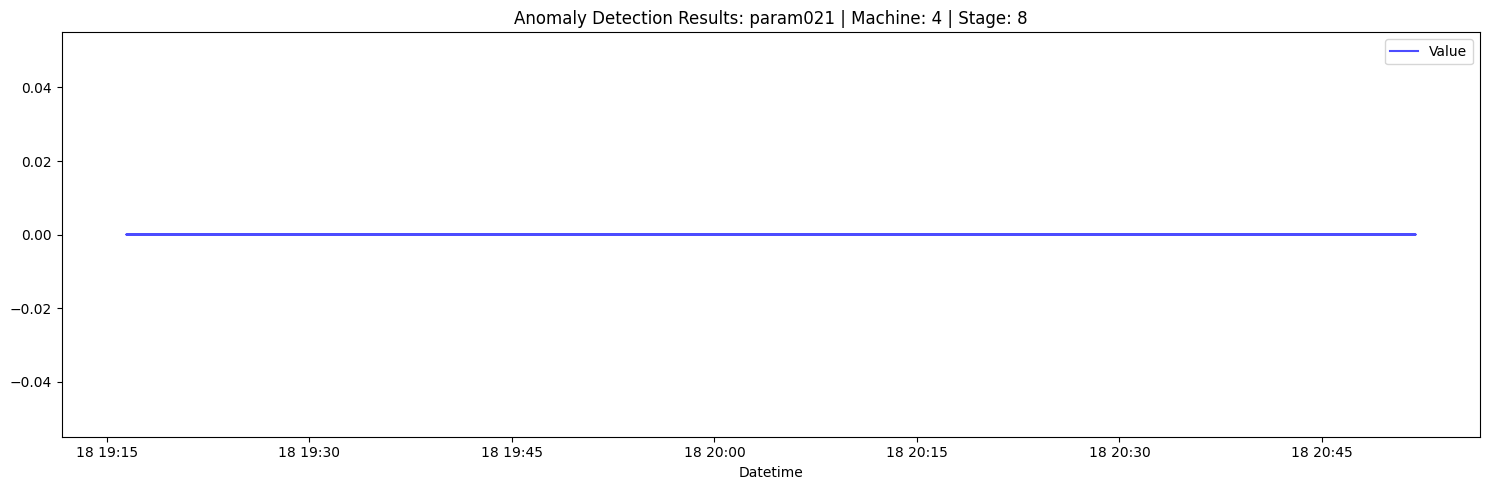

First 5 rows of param021:


,UniqueID,Machine,Datetime,Stage,raw_value,label,value,idx,predict,ad_len,alarm_level,anomaly_type
0,1001399,4,2024-12-18 19:29:47,8,0.0,0,0,800,0,0,no,no
1,1001399,4,2024-12-18 19:29:48,8,0.0,0,0,801,0,0,no,no
2,1001399,4,2024-12-18 19:29:49,8,0.0,0,0,802,0,0,no,no
3,1001399,4,2024-12-18 19:29:50,8,0.0,0,0,803,0,0,no,no
4,1001399,4,2024-12-18 19:29:51,8,0.0,0,0,804,0,0,no,no


In [17]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import glob
%matplotlib inline

# Find all predict.csv files in the result directory
predict_files = glob.glob(os.path.join(RESULT_DIR, '**', 'predict.csv'), recursive=True)

print(f"Searching for result files in: {RESULT_DIR}")
print(f"Found {len(predict_files)} result file(s) to visualize.")

for file_path in predict_files:
    try:
        df = pd.read_csv(file_path)
        if df.empty:
            print(f"Skipping empty file: {file_path}")
            continue
            
        # Extract file name/directory from path
        file_name = os.path.basename(os.path.dirname(file_path))
        
        # Check for Datetime column
        x_axis = df.index
        x_label = 'Index'
        if 'Datetime' in df.columns:
            df['Datetime'] = pd.to_datetime(df['Datetime'])
            x_axis = df['Datetime']
            x_label = 'Datetime'
        
        plt.figure(figsize=(15, 5))
        plt.plot(x_axis, df['value'], label='Value', alpha=0.7, color='blue')
        
        # Highlight anomalies
        if 'predict' in df.columns:
            anomalies = df[df['predict'] == 1]
            if not anomalies.empty:
                # Get corresponding x-axis values for anomalies
                anomaly_x = x_axis[anomalies.index]
                plt.scatter(anomaly_x, anomalies['value'], color='red', label='Predicted Anomaly', zorder=5)
            
        if 'label' in df.columns:
            true_anomalies = df[df['label'] == 1]
            if not true_anomalies.empty:
                 # Get corresponding x-axis values for true anomalies
                true_anomaly_x = x_axis[true_anomalies.index]
                plt.scatter(true_anomaly_x, true_anomalies['value'], marker='x', color='green', label='True Anomaly', s=50, zorder=6)
        
        # Add metadata to title if available
        title = f'Anomaly Detection Results: {file_name}'
        if 'Machine' in df.columns and not df['Machine'].empty:
            machine = df['Machine'].iloc[0]
            title += f" | Machine: {machine}"
        if 'Stage' in df.columns and not df['Stage'].empty:
            stage = df['Stage'].iloc[0]
            title += f" | Stage: {stage}"
            
        plt.title(title)
        plt.xlabel(x_label)
        plt.legend()
        plt.tight_layout()
        plt.show()
        
        print(f"First 5 rows of {file_name}:")
        display(df.head())
        
    except Exception as e:
        print(f"Error visualizing {file_path}: {e}")